In [12]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [119]:
# import keras
# from keras.datasets import mnist
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten
# from keras.layers import Conv2D, MaxPooling2D
# from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

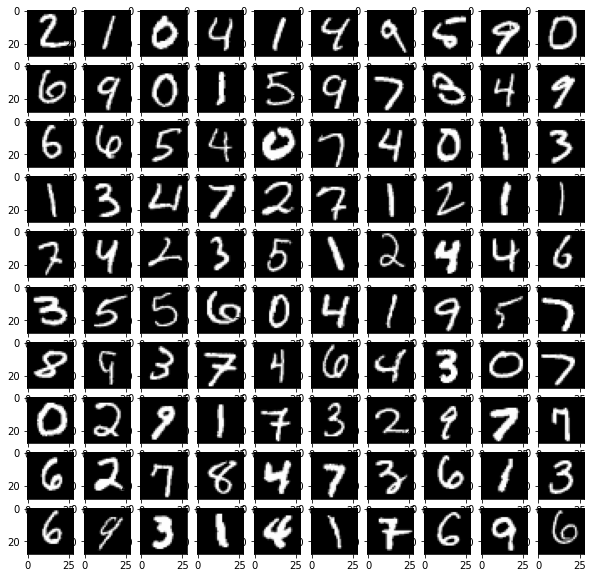

In [3]:
fig=plt.figure(figsize=(10, 10))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    img = x_test[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.show()

In [4]:
y_test[1:101]

array([2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6,
       5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3,
       5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6,
       4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6,
       1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6], dtype=uint8)

<hr>
<h2><u>Reshaping</u> train and test sets</h2>

In [5]:
# input image dimensions
img_rows, img_cols = 28, 28

#Keras expects data to be in the format (N_E.N_H,N_W,N_C)
#N_E = Number of Examples, N_H = height, N_W = Width, N_C = Number of Channels.
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
print(input_shape)

(28, 28, 1)


In [6]:
x_train.shape

(60000, 28, 28, 1)

<h3> Normalizing the input </h3>

In [7]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#Normalizing the input
x_train /= 255.0
x_test /= 255.0
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [37]:
batch_size = 128
num_classes = 10
epochs = 20

In [9]:
print(y_train.shape,'\n',y_train)

(60000,) 
 [5 0 4 ... 5 6 8]


In [10]:
# convert class vectors to binary class matrices(OHE)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [11]:
y_train[1]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

<hr>
<h2>Here comes the CNN </h2>

In [13]:
model = tf.keras.Sequential()

#Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'ReLU' 
model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

#Add a Convolutional Layer with 64 filters of size 3X3 and activation function as 'ReLU' 
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

In [17]:
#To use adam optimizer for learning weights with learning rate = 0.001
optimizer = tf.keras.optimizers.Adam(lr=0.001)

#Set the loss function and optimizer for the model training
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=optimizer,
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

<hr>
<h2>Training the <u>CNN</u>

In [28]:
from time import time
import os

#Setting the directory to store the logs.
NAME = 'mnist{}'.format(int(time()))
tboard_log_dir = os.path.join("logs",NAME)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir = tboard_log_dir)

In [29]:
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training
# model_checkpoint =  tf.keras.callbacks.ModelCheckpoint('mnist_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
#                                                            monitor='val_loss',
#                                                            verbose=1,
#                                                            save_best_only=True,
#                                                            save_weights_only=True,
#                                                            mode='auto',
#                                                            period=1)

In [38]:
#Training on the dataset and adding the all the callbacks to the fit function.
#Once the training starts, results start appearing on Tensorboard after 1 epoch
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[tensorboard,early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 8s 129us/sample - loss: 0.0107 - accuracy: 0.9965 - val_loss: 0.0438 - val_accuracy: 0.9914
Epoch 2/20
60000/60000 [==============================] - 8s 128us/sample - loss: 0.0110 - accuracy: 0.9962 - val_loss: 0.0331 - val_accuracy: 0.9931
Epoch 3/20
60000/60000 [==============================] - 8s 127us/sample - loss: 0.0116 - accuracy: 0.9962 - val_loss: 0.0331 - val_accuracy: 0.9923
Epoch 4/20
60000/60000 [==============================] - 8s 128us/sample - loss: 0.0090 - accuracy: 0.9969 - val_loss: 0.0304 - val_accuracy: 0.9933
Epoch 5/20
60000/60000 [==============================] - 8s 129us/sample - loss: 0.0097 - accuracy: 0.9970 - val_loss: 0.0322 - val_accuracy: 0.9936
Epoch 6/20
60000/60000 [==============================] - 8s 128us/sample - loss: 0.0098 - accuracy: 0.9966 - val_loss: 0.0348 - val_accuracy: 0.9926
Epoch 7/20
60000/60000 [==========================

In [41]:
#Testing the model on test set
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 1s 103us/sample - loss: 0.0404 - accuracy: 0.9933
Test loss: 0.04036961563506039
Test accuracy: 0.9933


<h4>Let's visualize a few cases </h4>

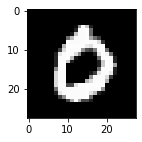

0


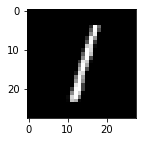

1


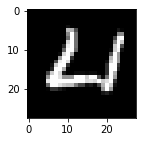

4


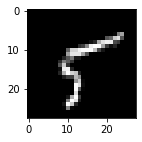

5


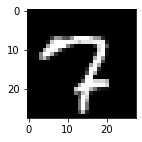

7


In [42]:
plt.figure(figsize=(2,2))
plt.imshow(x_test[3].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[3].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[2].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[2].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[33].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[33].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[59].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[59].reshape(1,28,28,1))))


plt.figure(figsize=(2,2))
plt.imshow(x_test[36].reshape(28,28),cmap="gray")
plt.show()
print(np.argmax(model.predict(x_test[36].reshape(1,28,28,1))))

In [45]:
#Set the path where you want to store the model and weights. 
model.save('./logs/cnn_mnist.h5')
model.save_weights('./logs/cnn_mnist_weights.h5')